In [2]:
import pandas as pd
import scipy.optimize as opt
import regularized_optimization as reg_opt
import Utilityfunctions as utils
import jax.numpy as jnp
import numpy as np
import jax as jax
import matplotlib.pyplot as plt
jax.config.update("jax_enable_x64", True)

In [26]:
dataset = "G12_PAADPANET_PM_z10_Events_30and5_Full"
cancer_type = "paad"

mut_name = f"../data/{cancer_type}/{dataset}.csv"
annot_name = f"../data/{cancer_type}/sampleSelection.txt"
annot_data = pd.read_table(annot_name, index_col=0) 
mut_data = pd.read_csv(mut_name, index_col=0)
dat = mut_data.join(annot_data["metaStatus"])


In [27]:
dat.drop()

,P.Mut.KRAS,M.Mut.KRAS,P.Mut.TP53,M.Mut.TP53,P.gAEP033,M.gAEP033,P.chr18.del.single.1,M.chr18.del.single.1,P.chrX.del.single.1,M.chrX.del.single.1,...,P.Mut.SF3B1,M.Mut.SF3B1,P.Mut.STK11,M.Mut.STK11,P.Mut.PTPRT,M.Mut.PTPRT,paired,P.AgeAtSeqRep,M.AgeAtSeqRep,metaStatus
GENIE-MSK-P-0000142,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,52,No metastasis included,present
GENIE-MSK-P-0000314,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,42,No metastasis included,unknown
GENIE-MSK-P-0000421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,No primary included,64,isMetastasis
GENIE-MSK-P-0000783,1,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,60,No metastasis included,present
GENIE-MSK-P-0000879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,No primary included,36,isMetastasis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GENIE-MSK-P-0065136,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,No metastasis included,unknown
GENIE-MSK-P-0065134,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,No metastasis included,unknown
GENIE-MSK-P-0067218,0,1,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,No primary included,NaN,isMetastasis
GENIE-MSK-P-0062309,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,No primary included,NaN,isMetastasis


In [20]:
# Remove datapoints that consist solely of NaNs
dat = dat.loc[dat.iloc[:,1:-3].isna().all(axis=1) == False, :]
dat = dat.loc[(dat.iloc[:,1:-3].sum(axis=1) > 0), :]
dat2 = dat.copy()
dat3 = dat[dat[events[:-1]].sum(axis=1)==0]
dat3.loc[dat3.metaStatus == "paired"]
mut_data.columns

NameError: name 'events' is not defined

In [ ]:
dat2["Seeding"] = 0
dat2.loc[dat2.paired==True, 'Seeding'] = 1
dat2.loc[(dat2.paired == False) & (dat2.metaStatus == "absent"), "Seeding"] = 0
dat2.loc[(dat2.paired == False) & (dat2.metaStatus == "present"),'Seeding'] = 1
dat2.loc[(dat2.paired == False) & (dat2.metaStatus == "isMetastasis"), 'Seeding'] = 1

In [ ]:
def co_oc_mat(dat, events):
    n_events = events.shape[0]
    co_oc = np.full((n_events, n_events), np.NAN)
    for i in range(n_events):
        for j in range(i+1):
            co_oc[i, j] = dat.loc[(dat[events[i]] == 1) & (dat[events[j]] == 1),:].shape[0]
    return co_oc/dat.shape[0]

In [ ]:
# Events in primary tumors
events_prim = np.append(np.array(dat2.columns[1:-5:2]), ["Seeding"])
dat_ps = dat2.loc[dat2.metaStatus == "absent", : ]
co_oc_ps = co_oc_mat(dat_ps, events_prim)
dat_ps_ms = dat2.loc[dat2.metaStatus == "present", : ]
co_oc_ms = co_oc_mat(dat_ps_ms, events_prim) 
dat_mt = dat2.loc[dat2.metaStatus == "isMetastasis", : ]
events_met = np.append(np.array(dat2.columns[2:-5:2]), ["Seeding"])
co_oc_mt = co_oc_mat(dat_mt, events_met)
co_oc_ms.shape

In [ ]:
# Metastases
f, ax = plt.subplots(figsize=(19,15))
ax.matshow(co_oc_mt)
plt.xticks(range(co_oc_mt.shape[1]), events_met, fontsize=14, rotation=90)
plt.yticks(range(co_oc_mt.shape[1]), events_met, fontsize=14)
current_cmap = plt.cm.get_cmap()
current_cmap.set_bad(color='red')
#cb = ax.colorbar()
#cb.ax.tick_params(labelsize=14)
for i in range(events_met.shape[0]):
    for j in range(i+1):
        c = np.round(co_oc_mt[i,j], 2)
        ax.text(j, i, str(c), va='center', ha='center')
plt.show()


In [ ]:
# Prims with metastases
f, ax = plt.subplots(figsize=(19,15))#plt.figure(figsize=(19, 15))
ax.matshow(co_oc_ms)
plt.xticks(range(co_oc_ms.shape[1]), events_prim, fontsize=14, rotation=90)
plt.yticks(range(co_oc_ms.shape[1]), events_prim, fontsize=14)
current_cmap = plt.cm.get_cmap()
current_cmap.set_bad(color='red')
#cb = ax.colorbar()
#cb.ax.tick_params(labelsize=14)

for i in range(events_prim.shape[0]):
    for j in range(i+1):
        c = np.round(co_oc_ms[i,j], 2)
        ax.text(j, i, str(c), va='center', ha='center')
plt.show()

In [ ]:
# Prims without mets
f, ax = plt.subplots(figsize=(19,15))#plt.figure(figsize=(19, 15))
ax.matshow(co_oc_ps)
plt.xticks(range(co_oc_ps.shape[1]), events_prim, fontsize=14, rotation=90)
plt.yticks(range(co_oc_ps.shape[1]), events_prim, fontsize=14)
current_cmap = plt.cm.get_cmap()
current_cmap.set_bad(color='red')
#cb = ax.colorbar()
#cb.ax.tick_params(labelsize=14)

for i in range(events_prim.shape[0]):
    for j in range(i+1):
        c = np.round(co_oc_ps[i,j], 2)
        ax.text(j, i, str(c), va='center', ha='center')
plt.show()

In [36]:
# Select coupled datapoints
start = 'P.Mut.KRAS'
stop = 'M.Mut.PTPRT'
dat_coupled =  dat.loc[dat.paired==True,start:stop]
dat_coupled['Seeding'] = 1
dat_coupled = dat_coupled.to_numpy(dtype = int)
dat_coupled = jnp.array(dat_coupled)

# select prim only + no metastastasis generated 
dat_prim_nomet =  dat.loc[(dat.paired == False) & (dat.metaStatus == "absent"), start:stop]
dat_prim_nomet['Seeding'] = 0
dat_prim_nomet = dat_prim_nomet.to_numpy(dtype = int)
dat_prim_nomet = jnp.array(dat_prim_nomet)

# select prim_only + no metastasis_sequenced
dat_prim_met =  dat.loc[(dat.paired == False) & (dat.metaStatus == "present"), start:stop]
dat_prim_met['Seeding'] = 1
dat_prim_met = dat_prim_met.to_numpy(dtype = int)
dat_prim_met = jnp.array(dat_prim_met)

# select metastasis only
dat_met_only =  dat.loc[(dat.paired == False) & (dat.metaStatus == "isMetastasis"), start:stop]
dat_met_only['Seeding'] = 1
dat_met_only = dat_met_only.to_numpy(dtype = int)
dat_met_only = jnp.array(dat_met_only)

events = list(dat.columns[1:-4:2])
events.append("Seeding")
dat = jnp.vstack((dat_prim_nomet, dat_prim_met, dat_coupled, dat_met_only))
print(dat_prim_nomet.shape[0], dat_prim_met.shape[0], dat_coupled.shape[0], dat_met_only.shape[0])

14


TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [31]:
print(dat_coupled.sum(axis=1))

[ 6 11 10  3 11  4  5 11  9 10  5  6 11  7  9  8  8  6  5 13  9  4  5  8
  7  7  8 14 11  7  7  3 13  9  9 11  5 15  8 10 14  5  8  5  7  9  5 15
  7  6  5 10  9  7  4  5 12  5  6 12 10 10  9  6  4  5  7  9  6 13 14  6
  9 11]


In [19]:
n = (dat.shape[1] -1)//2
n += 1
lam1_start = np.log(30/391)
lam2_start = np.log(30/391) # observed mean time to second diagnosis is 391 days
indep = utils.indep(dat)
indep = indep.at[np.diag_indices(n)].add(lam2_start) # Assumption diagnosis and progression rates are on the same scale
start_params = np.append(indep, [lam1_start, lam2_start])
print(start_params)

[-2.726049    0.          0.         ...  0.29662587 -2.56751018
 -2.56751018]


In [20]:
dat_coupled = dat_coupled.at[dat_coupled.sum(axis=1) > 1, ].get()

In [21]:
reg_opt.log_lik(start_params, dat_prim_met, dat_prim_nomet, dat_coupled, dat_met_only, 0.01, 0.8)

14.094491594278278

In [22]:
res = reg_opt.grad(start_params, dat_prim_met, dat_prim_nomet, dat_coupled, dat_met_only, 0.01, 0.8)
res

array([-0.15686603, -0.15878594,  0.09716283, ...,  0.38691363,
        0.40709041,  0.        ])

In [26]:
penal = 0.012
m_p_corr = 0.8
x = opt.minimize(reg_opt.log_lik, x0 = start_params, args = (dat_prim_nomet, dat_prim_met, dat_coupled, dat_met_only, penal, m_p_corr), 
                method = "L-BFGS-B", jac = reg_opt.grad, options={"maxiter":10000, "disp":True, "ftol":1e-05})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1298     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60628D+01    |proj g|=  1.18098D+00


 This problem is unconstrained.



At iterate    1    f=  1.46857D+01    |proj g|=  1.00952D+00

At iterate    2    f=  1.35449D+01    |proj g|=  2.97153D-01

At iterate    3    f=  1.32514D+01    |proj g|=  1.28854D-01

At iterate    4    f=  1.30016D+01    |proj g|=  1.57418D-01

At iterate    5    f=  1.27032D+01    |proj g|=  2.98463D-01

At iterate    6    f=  1.24903D+01    |proj g|=  1.59285D-01

At iterate    7    f=  1.24031D+01    |proj g|=  4.30358D-02

At iterate    8    f=  1.23153D+01    |proj g|=  6.85153D-02

At iterate    9    f=  1.22886D+01    |proj g|=  9.23420D-02

At iterate   10    f=  1.22084D+01    |proj g|=  4.09969D-02

At iterate   11    f=  1.22013D+01    |proj g|=  5.96237D-02

At iterate   12    f=  1.21262D+01    |proj g|=  3.55778D-02

At iterate   13    f=  1.21171D+01    |proj g|=  4.16661D-02

At iterate   14    f=  1.20615D+01    |proj g|=  2.36698D-02

At iterate   15    f=  1.20418D+01    |proj g|=  2.04180D-02

At iterate   16    f=  1.20246D+01    |proj g|=  2.57507D-02

At iter

In [29]:
print(1/jnp.exp(x.x[-2]))
df2 = pd.DataFrame(x.x[:-2].reshape((n, n)), columns=events, index=events)
df = df2.copy()
df2["Sampling"] = np.append(np.array(x.x[-2:]), np.zeros(n-2))
df2.to_csv("../results/paad_panet_" + "muts_30_5_08_008" + ".csv")
df2.round(3)

22.75133845633727


,P.Mut.KRAS,P.Mut.TP53,P.gAEP033,P.chr18.del.single.1,P.chrX.del.single.1,P.Mut.SMAD4,P.chr20.amp.single.1,P.chr17.del.single.1,P.Mut.CDKN2A,P.Mut.ARID1A,...,P.Mut.SMAD3,P.Mut.MAP2K4,P.Mut.TSC2,P.Mut.BCOR,P.Mut.U2AF1,P.Mut.SF3B1,P.Mut.STK11,P.Mut.PTPRT,Seeding,Sampling
P.Mut.KRAS,-2.018,-0.040,-0.711,-0.001,0.000,1.565,-1.421,-0.000,-0.000,0.001,...,-0.000,0.001,-0.001,-0.000,0.001,0.001,0.000,-0.000,-0.968,-3.125
P.Mut.TP53,2.508,-4.652,-0.011,-0.042,0.001,-0.026,-0.001,0.001,0.721,0.003,...,-0.000,-1.530,0.001,0.000,-0.001,-1.014,-0.000,0.000,-0.233,-2.568
P.gAEP033,-0.523,0.005,-4.997,2.929,0.036,0.001,2.438,0.255,0.000,-0.209,...,0.000,0.001,-0.002,-0.000,0.000,-0.002,0.000,-0.000,0.125,0.000
P.chr18.del.single.1,0.074,0.000,1.683,-4.752,0.014,-0.001,-0.004,0.014,0.472,0.000,...,0.000,0.002,0.001,0.000,0.010,0.002,-0.000,-0.000,-0.163,0.000
P.chrX.del.single.1,0.001,0.307,0.549,2.133,-5.784,-0.003,-0.000,-0.000,0.004,0.109,...,0.001,-0.002,0.002,-0.000,-0.002,-0.001,0.000,-0.000,-0.310,0.000
P.Mut.SMAD4,-0.001,-0.271,-0.100,-0.044,-0.343,-4.242,-0.002,-0.002,0.001,0.000,...,-0.001,-0.002,-0.001,-0.000,-0.000,-0.001,-0.000,-0.000,-1.113,0.000
P.chr20.amp.single.1,-0.489,-0.015,-0.004,0.001,-0.000,0.000,-4.280,-0.002,0.002,-0.039,...,-0.001,0.003,-0.009,-0.000,-0.000,-0.001,-0.000,-0.000,-0.658,0.000
P.chr17.del.single.1,0.518,-0.001,1.710,1.509,-0.001,-0.029,-0.005,-6.569,-0.002,-0.586,...,0.001,0.002,0.003,-0.000,-0.002,-0.000,0.000,0.000,-0.003,0.000
P.Mut.CDKN2A,0.001,-0.000,-0.005,-0.002,-0.001,0.002,-0.001,-0.001,-5.154,-0.000,...,0.001,-0.001,-0.002,0.000,-0.000,-0.000,-0.000,-0.000,-0.414,0.000
P.Mut.ARID1A,-0.533,-0.517,-0.003,-0.001,0.000,-0.004,-0.411,-0.002,-0.001,-5.380,...,0.001,-0.000,-0.001,0.000,-0.000,-0.000,-0.000,-0.000,-0.147,0.000


/var/folders/tv/440md0xj1bx6jrc_cqw578j00000gr/T/ipykernel_12374/89587887.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  current_cmap = plt.cm.get_cmap()


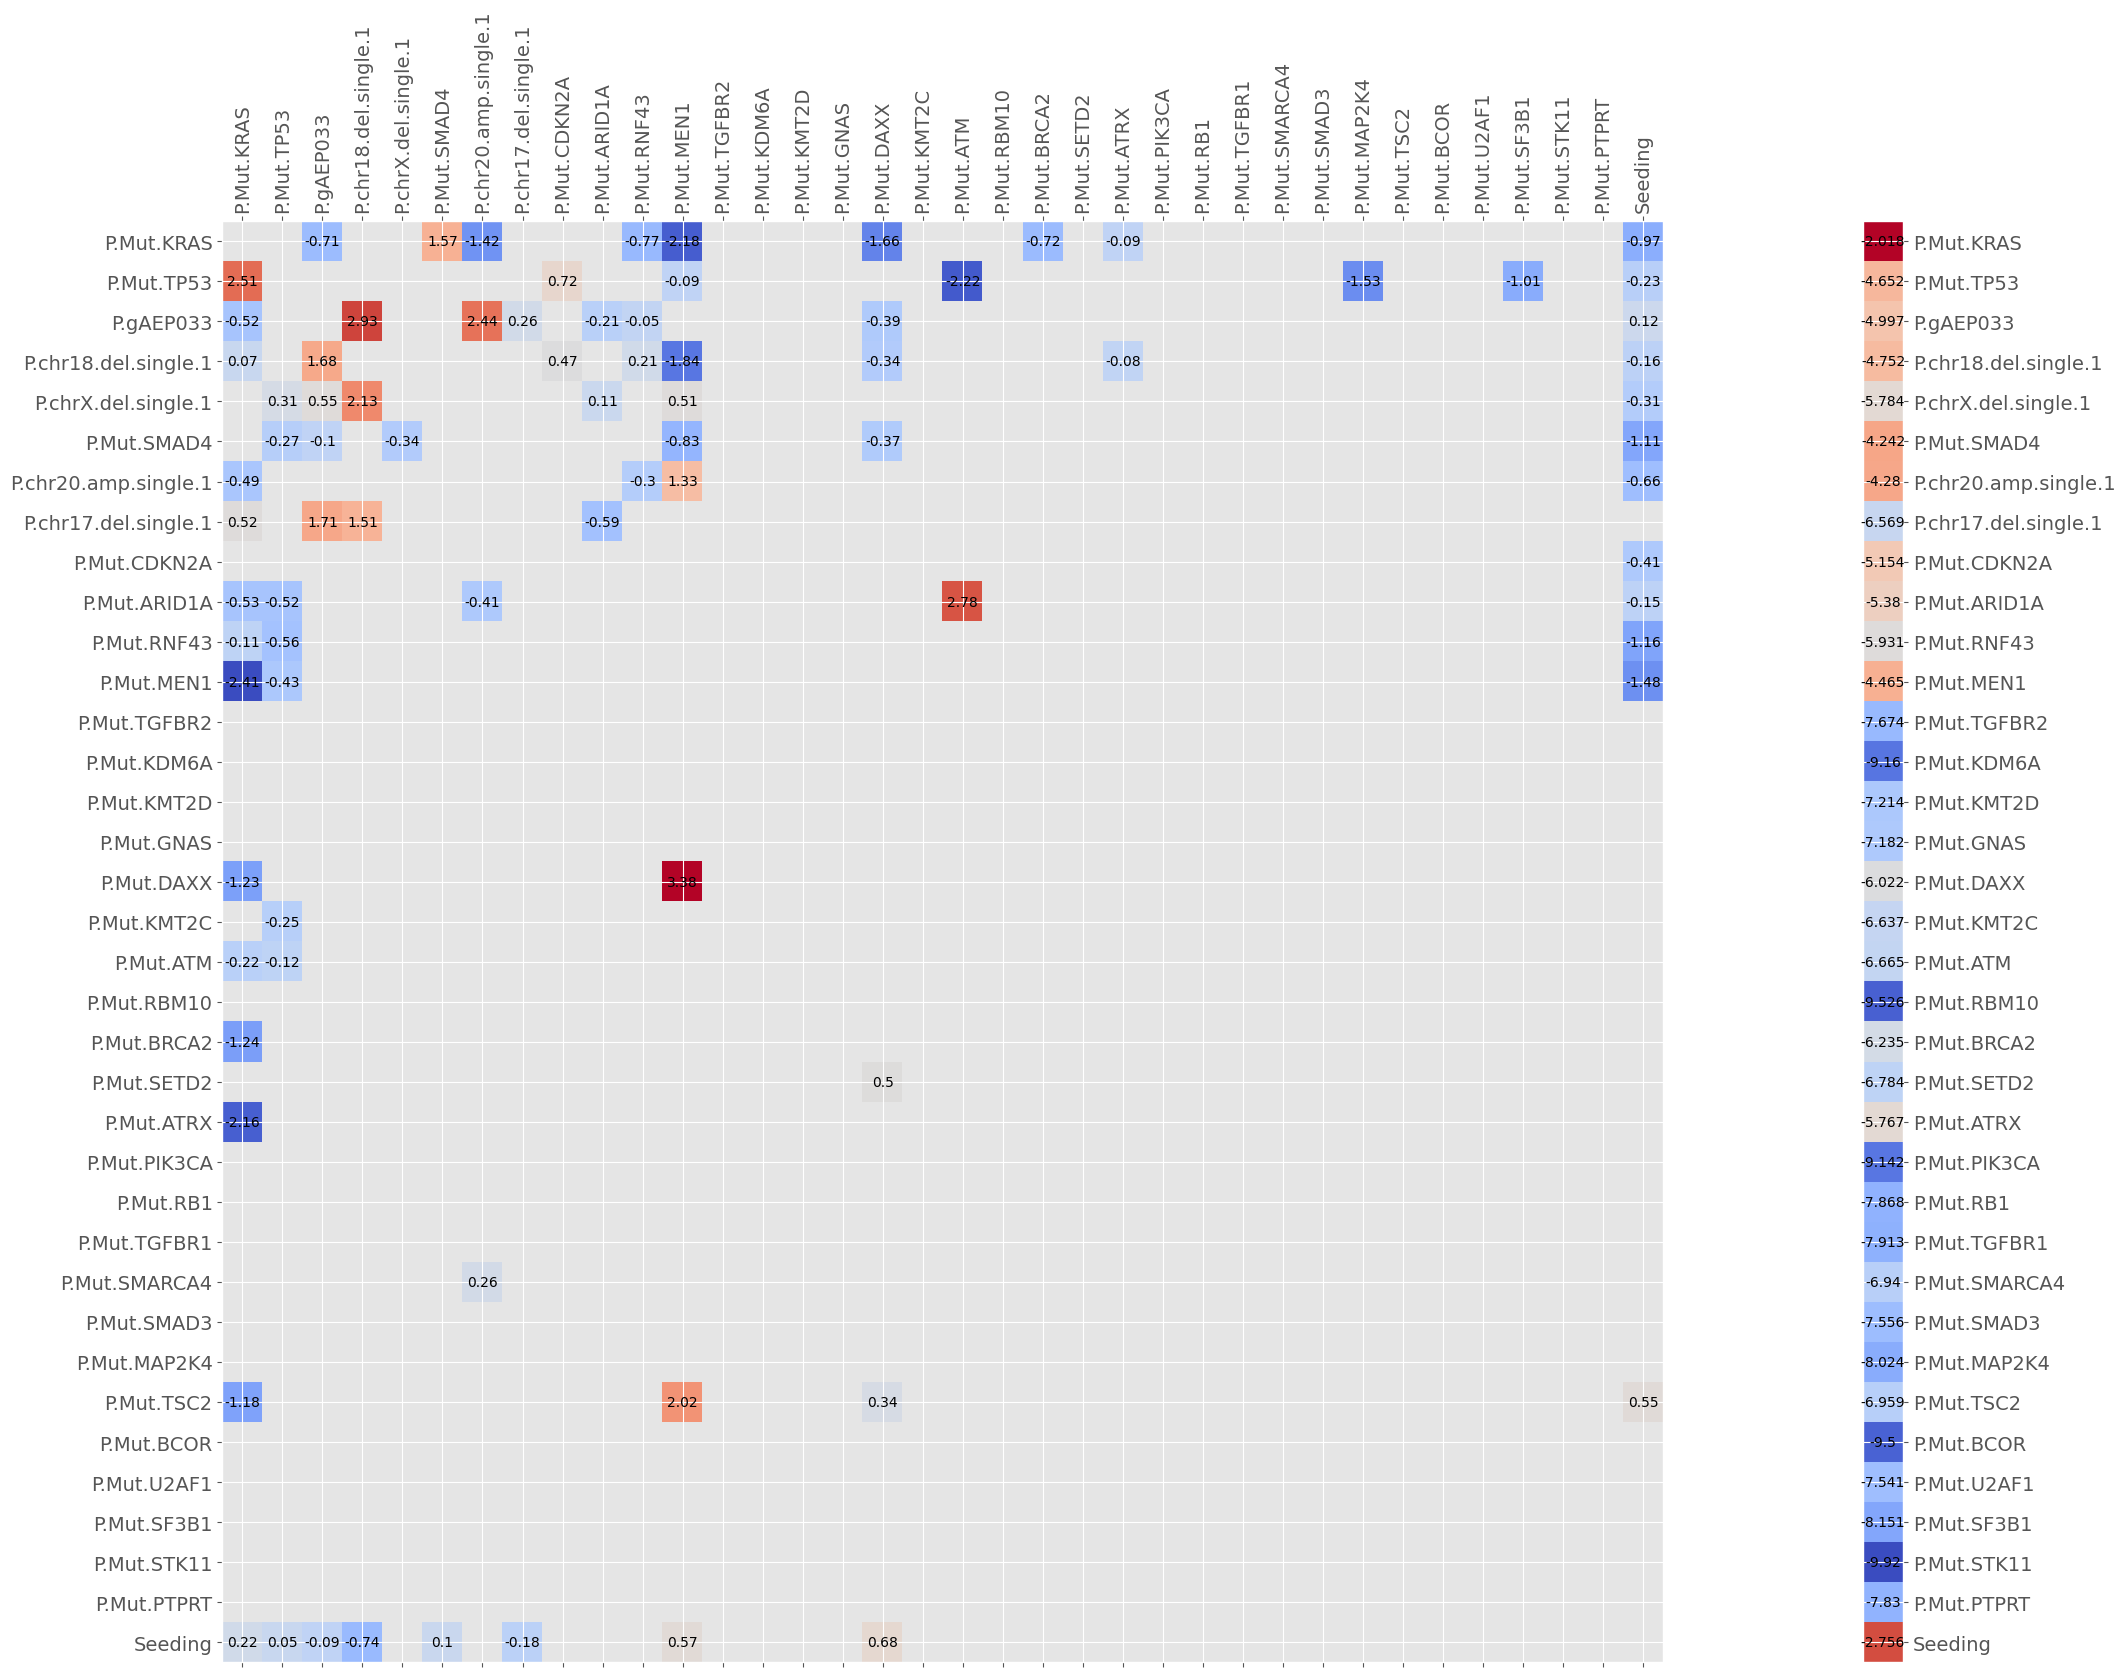

In [28]:
df[(df.round(2) == 0) | (df.round(2) == -0)] = np.nan
df[df.abs() < 0.05] = np.nan
theta_diag = np.diag(df.copy()).reshape((-1,1))
np.fill_diagonal(df.values, np.nan)

plt.style.use("ggplot")
f, (ax, ax2) = plt.subplots(1, 2, figsize=(19,15), gridspec_kw={'width_ratios': [6, 1]})
f.tight_layout()
ax.matshow(df, cmap="coolwarm")
ax2.matshow(theta_diag, cmap="coolwarm")
ax.set_xticks(range(df.shape[1]), events, fontsize=14, rotation=90)
ax.set_yticks(range(df.shape[1]), events, fontsize=14)
ax2.set_yticks(range(df.shape[1]), events, fontsize=14)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xticks([])
current_cmap = plt.cm.get_cmap()
current_cmap.set_bad(color='black')


for i in range(n):
    for j in range(n):
        if np.isnan(df.iloc[i,j]) == False:
            c = np.round(df.iloc[i,j].round(2), 2)
        else:
            c = ""
        ax.text(j, i, str(c), va='center', ha='center')
    ax2.text(0, i, np.round(theta_diag[i,0],3), va='center', ha='center')
plt.show()